In [1]:
%matplotlib inline

In [2]:
################################################################################
# SCRIPT ONE - READ DISTRIBUTION ANALYSIS FROM BASECALLED READS IN FASTA FILES #
################################################################################


### IMPORTING MODULES AND DEFINING INPUT-NECESSARY PARAMETERS ###

# Importing relevant modules: 
# * dataframe - pandas 
# * graphs - matplotlib 
# * tools - numpy, random, fnmatch, os
# * fasta to dataframe conversion - SeqIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import shutil
import pandas as pd
import random
import collections
import math
from pandas.tools.plotting import table
from itertools import product
from Bio import SeqIO



In [3]:
!pwd

/home/yiheng/MinION_data/scripts/notebooks/Gamran_script


In [19]:
BASEFOLDER = '/home/yiheng/MinION_data/20170617_FAH05432_WAG0003'
# define root directory within which to create a subdirectory system
# define input paths for basecalled read fasta files, rgbesthit and ncbibesthit files
work_dir = os.path.abspath(BASEFOLDER) + '/'
fasta_input_dir_path = os.path.abspath(BASEFOLDER) + '/basecalled_data' +'/'
rgbesthit_input_dir_path = os.path.abspath(BASEFOLDER) + '/blast' + '/'
ncbibesthit_input_dir_path = os.path.abspath(BASEFOLDER) + '/blast' + '/'
# parameters that need to be hard-coded: 
# - the barcodes tested for
# - the reference genome tag list, unique identifiers decided on from the sseqids of the ref genomes
# - the reference genome full species names, in the same order as the ref genome tags
good_barcodes = ['BC01', 'BC02', 'BC03', 'BC04', 'BC05', 'BC06', 'BC07']
ref_genome_tag_list = ['TGAC', 'Zymo', 'Ptri', 'Pst', 'tig']
ref_genome_species_list = ['Wheat', 
                        'Zymoseptoria tritici', 
                        'Pyrenophore tritici-repentis', 
                        'P. striformis f. sp. tritici WA', 
                        'Parastagonospora nodorum']

In [20]:

#-------------------------------------------------------------------------------

### CREATING THE SUBDIRECTORY SYSTEM INSIDE A SPECIFIED MAIN DIRECTORY ###

# Functions that generate main work directories and subdirectories for:
# * data (all fasta files)
# * blast (all blast output files)
# * analysis (all dataframe summary and graph files)
# when given a top directory path
def create_main_directories(top_dir):
    """Given a top work directory, creates 3 main subdirectories - data, blast and analysis"""
    main_directory_list = ['data/', 'blast/', 'output/']
    for new_direct in main_directory_list:
        if not os.path.exists(top_dir + new_direct):
            os.makedirs(top_dir + new_direct)

def create_data_subdirectories(top_dir):
    data_subdirectory_list = ['basecalled/',
                        'rghityes/',
                        'rghitno/',
                        'rghitsamples/']
    data_subsubdirectory_list = ['ncbihityes/',
                                 'ncbihitno/']
    for new_subdirect in data_subdirectory_list:
        if not os.path.exists(top_dir + 'data/' + new_subdirect):
            os.makedirs(top_dir + 'data/' + new_subdirect)
    for new_subsubdirect in data_subsubdirectory_list:
        if not os.path.exists(top_dir + 'data/rghitno/' + new_subsubdirect):
            os.makedirs(top_dir + 'data/rghitno/' + new_subsubdirect)

def create_blast_subdirectories(top_dir):
    blast_subdirectory_list = ['rgbesthit/',
                               'ncbibesthit/']
    for new_subdirect in blast_subdirectory_list:
        if not os.path.exists(top_dir + 'blast/' + new_subdirect):
            os.makedirs(top_dir + 'blast/' + new_subdirect)

def create_analysis_subdirectories(top_dir):
    analysis_subdirectory_list = ['graphs/',
                                  'tables/',
                               'summaries/']
    for new_subdirect in analysis_subdirectory_list:
        if not os.path.exists(top_dir + 'analysis/' + new_subdirect):
            os.makedirs(top_dir + 'analysis/' + new_subdirect)


# Apply previous functions to generate data, blast and analysis directories and subdirectories:
create_main_directories(work_dir)
create_data_subdirectories(work_dir)
create_blast_subdirectories(work_dir)
create_analysis_subdirectories(work_dir)

In [21]:

#-------------------------------------------------------------------------------

### MOVING THE BASECALLED FASTA FILES FROM AN INPUT FOLDER TO THE ~/DATA/BASECALLED SUB-DIRECTORY ###

# Define a function that extracts the file type from the fastas
def get_file_type(string, delimiter):
    file_type = string.split(delimiter)
    return delimiter + file_type[-1]


#Extracts fasta files from the initial input folder and moves them to ~/data/basecalled to be manipulated
fasta_input_file_names = [x for x in os.listdir(fasta_input_dir_path) if x.endswith('.fasta')]
fasta_input_file_names.sort()
if fasta_input_file_names:
    for fasta_file in fasta_input_file_names:
        if os.path.exists(fasta_input_dir_path + fasta_file):
            if not os.path.exists(work_dir + 'data/basecalled/' + fasta_file):
                shutil.copy2(fasta_input_dir_path + fasta_file, work_dir + 'data/basecalled/' + fasta_file)
    fasta_file_type = get_file_type(fasta_input_file_names[-1], '.')

    
#-------------------------------------------------------------------------------

### EXTRACT BARCODES AND FASTA IDS FROM THE FASTA FILES IN ~/DATA/BASECALLED ###
  
#Generates a list of all fasta files present in data/basecalled
basecalled_file_names = os.listdir(work_dir + 'data/basecalled')
basecalled_fasta_file_names = [x for x in basecalled_file_names if x.endswith(fasta_file_type)]
basecalled_fasta_file_names.sort()


#Make a list of all available barcodes the basecalled reads are sorted into, based on fasta file names
basecalled_fasta_barcodes = []
for bcs in range(0, len(basecalled_fasta_file_names)):
    bclabel_index = ''
    if int(basecalled_fasta_file_names[bcs].rfind('BC')) > int(basecalled_fasta_file_names[bcs].rfind('NB')):
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('BC'))
    else:
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('NB'))
    basecalled_fasta_barcodes.append(basecalled_fasta_file_names[bcs][bclabel_index:bclabel_index + 4]) #Convert to a search parameter? Try this Yiheng!

####working up to here

In [22]:
#Extracts the ID from the basecalled file names (everything before BC/NB??.fa)
basecalled_fasta_file_id_list = []
for file_name in basecalled_fasta_file_names:
    print(file_name)
    bclabel_index = ''
    if int(file_name.rfind('BC')) > int(file_name.rfind('NB')):
        bclabel_index = int(file_name.rfind('BC'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
    else:
        bclabel_index = int(file_name.rfind('NB'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
  
basecalled_fasta_file_id = list(set(basecalled_fasta_file_id_list))[0]

20170617_WAG0003_BC00.fasta
20170617_WAG0003_BC01.fasta
20170617_WAG0003_BC02.fasta
20170617_WAG0003_BC03.fasta
20170617_WAG0003_BC04.fasta
20170617_WAG0003_BC05.fasta
20170617_WAG0003_BC06.fasta
20170617_WAG0003_BC07.fasta
20170617_WAG0003_NB00.fasta


In [23]:
basecalled_fasta_file_id_list

['20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_',
 '20170617_WAG0003_']

In [24]:
#-------------------------------------------------------------------------------

### GENERATE SUMMARY OF ALL BASECALLED READS (READ ID, BARCODE, LENGTH, GOOD OR BAD BARCODE) ###

#Specifies all barcodes and bad barcodes (good_barcodes is previously defined)
all_barcodes = basecalled_fasta_barcodes
bad_barcodes = sorted(list(set(all_barcodes) - set(good_barcodes)))


#Create lengths.txt file to summarise read_id, barcode and length for basecalled reads, save in analysis/summaries/
analysis_summaries_path = work_dir + 'analysis/summaries/'
#maybe change the name of this variable
complete_path_and_name = os.path.join(analysis_summaries_path, basecalled_fasta_file_id + "lengths.txt")
lengths_txt = open(complete_path_and_name, "w")
print("Read_id,Barcode,Length,Quality", file=lengths_txt)


# From each read, write rlsead_id, barcode, length, and good/bad barcode info into the text file.
# All other barcodes besides the good barcodes are labelled under 'NB00'
os.chdir(work_dir + 'data/basecalled/')
for bcs, fa_file in zip(basecalled_fasta_barcodes, basecalled_fasta_file_names):
    for seq in SeqIO.parse(open(fa_file), 'fasta'):
        if bcs in good_barcodes:
            print(seq.id + "," + bcs + "," + str(len(seq)) + "," + 'Good', file=lengths_txt)
        elif bcs in bad_barcodes:
            print(seq.id + "," + 'NB00' + "," + str(len(seq)) + "," + 'Bad', file=lengths_txt)
        else:
            continue
lengths_txt.close()
os.chdir(work_dir)

b'Skipping line 182458: expected 4 fields, saw 46\nSkipping line 258159: expected 4 fields, saw 103\n'
b'Skipping line 604831: expected 4 fields, saw 58\n'
b'Skipping line 1410001: expected 4 fields, saw 177\nSkipping line 1416654: expected 4 fields, saw 96\n'
/home/yiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.


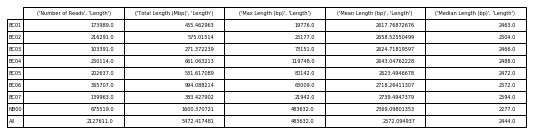

In [25]:
#-------------------------------------------------------------------------------

### ANALYSE BASECALLED READ SUMMARY (GET MAX, MIN, MEAN, MEDIAN, COUNT) ###

# Convert the lengths.txt file to a manipulatible pandas dataframe
basecalled_df = pd.read_csv(complete_path_and_name, error_bad_lines=False)


# Summarises the dataframe to show read count, sum, max, mean, median of read lengths per barcode
basecalled_df_pivot = basecalled_df.pivot_table(values='Length', 
                                                index='Barcode', 
                                                aggfunc=[len, np.sum, np.max, np.mean, np.median],
                                                fill_value=0, 
                                                margins=True)
basecalled_df_pivot.index.name = None
#change display options  of floats
pd.options.display.float_format = '{:.0f}'.format
for clmns in ['len', 'amax', 'median']:
    basecalled_df_pivot[clmns] = basecalled_df_pivot[clmns].astype(int)
basecalled_df_pivot['sum'] = basecalled_df_pivot['sum']/1000000

basecalled_df_pivot_formal = basecalled_df_pivot.copy() #titles have whitespace, make fancier
basecalled_df_pivot_formal.rename(columns={'len': 'Number of Reads', 
                                    'sum': 'Total Length (Mbp)',
                                    'amax': 'Max Length (bp)',
                                    'mean': 'Mean Length (bp)',
                                    'median': 'Median Length (bp)'}, inplace=True)

# Saves the table summary in the ~/analysis/tables/ subdirectory
fig = plt.figure(figsize=(9,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, basecalled_df_pivot_formal, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "_basecalled_reads_summary.png"))



In [26]:
basecalled_df_pivot_formal

,Number of Reads,Total Length (Mbp),Max Length (bp),Mean Length (bp),Median Length (bp)
,Length,Length,Length,Length,Length
BC01,173989,455,19776,2618,2463
BC02,216291,575,25177,2659,2504
BC03,103391,271,73151,2625,2466
BC04,250114,661,119748,2643,2488
BC05,202637,532,80142,2623,2472
BC06,365707,994,63009,2718,2572
BC07,139963,383,21942,2739,2594
NB00,675519,1600,483632,2369,2277
All,2127611,5472,483632,2572,2444


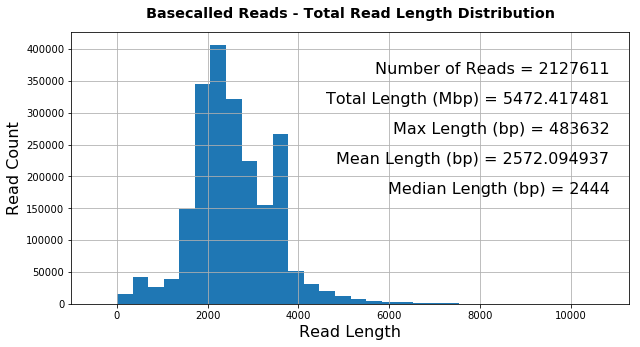

In [27]:

#-------------------------------------------------------------------------------

### CONSTRUCT HISTOGRAMS CHARTING READ DISTRIBUTION, BASED FROM THE DATAFRAME ###
bc_list = basecalled_df_pivot.index
bc_list = list(bc_list)
bc_list.remove('All')
# Function that generates a random colour
def random_color(x=1):
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))


#Generates a histogram showing the total read length distribution for all basecalled reads
plt.figure(figsize=(10,5))
basecalled_df[basecalled_df.Length < basecalled_df.Length.mean()*4]['Length'].hist(bins=30)

plt.title('Basecalled Reads - Total Read Length Distribution', y=1.03, fontsize='x-large', fontweight='bold')

plt.xlabel('Read Length', fontsize=16)
plt.xticks(np.arange(0, basecalled_df.Length.mean()*4 + 1, 2000))
plt.xlim([-1000, basecalled_df.Length.mean()*4 + 1000])

plt.ylabel('Read Count', fontsize=16)


for idx, clmn_name in enumerate(list(basecalled_df_pivot_formal.columns)):
    plt.annotate(clmn_name[0] + ' = ' + str(basecalled_df_pivot_formal[clmn_name]['All']), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')
    
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'basecalled_read_distribution_total.png', bbox_inches='tight')

#plt.figure()

In [28]:
basecalled_df.head()

,Read_id,Barcode,Length,Quality
0,054679a0-72f0-49b5-a2d9-2946b8766cf8,NB00,996,Bad
1,614be062-66cc-47a6-b569-b4f84240b5bc,NB00,2446,Bad
2,9151115d-8f47-4be0-881f-a2c9cff65ced,NB00,2028,Bad
3,dfa503b1-af91-4a04-ae39-40bf8b31439c,NB00,2499,Bad
4,b687371b-848a-4383-8fd8-1697eacdc3e5,NB00,1815,Bad


In [29]:
subset_df = basecalled_df[basecalled_df.Length < basecalled_df.Length.mean()*4]

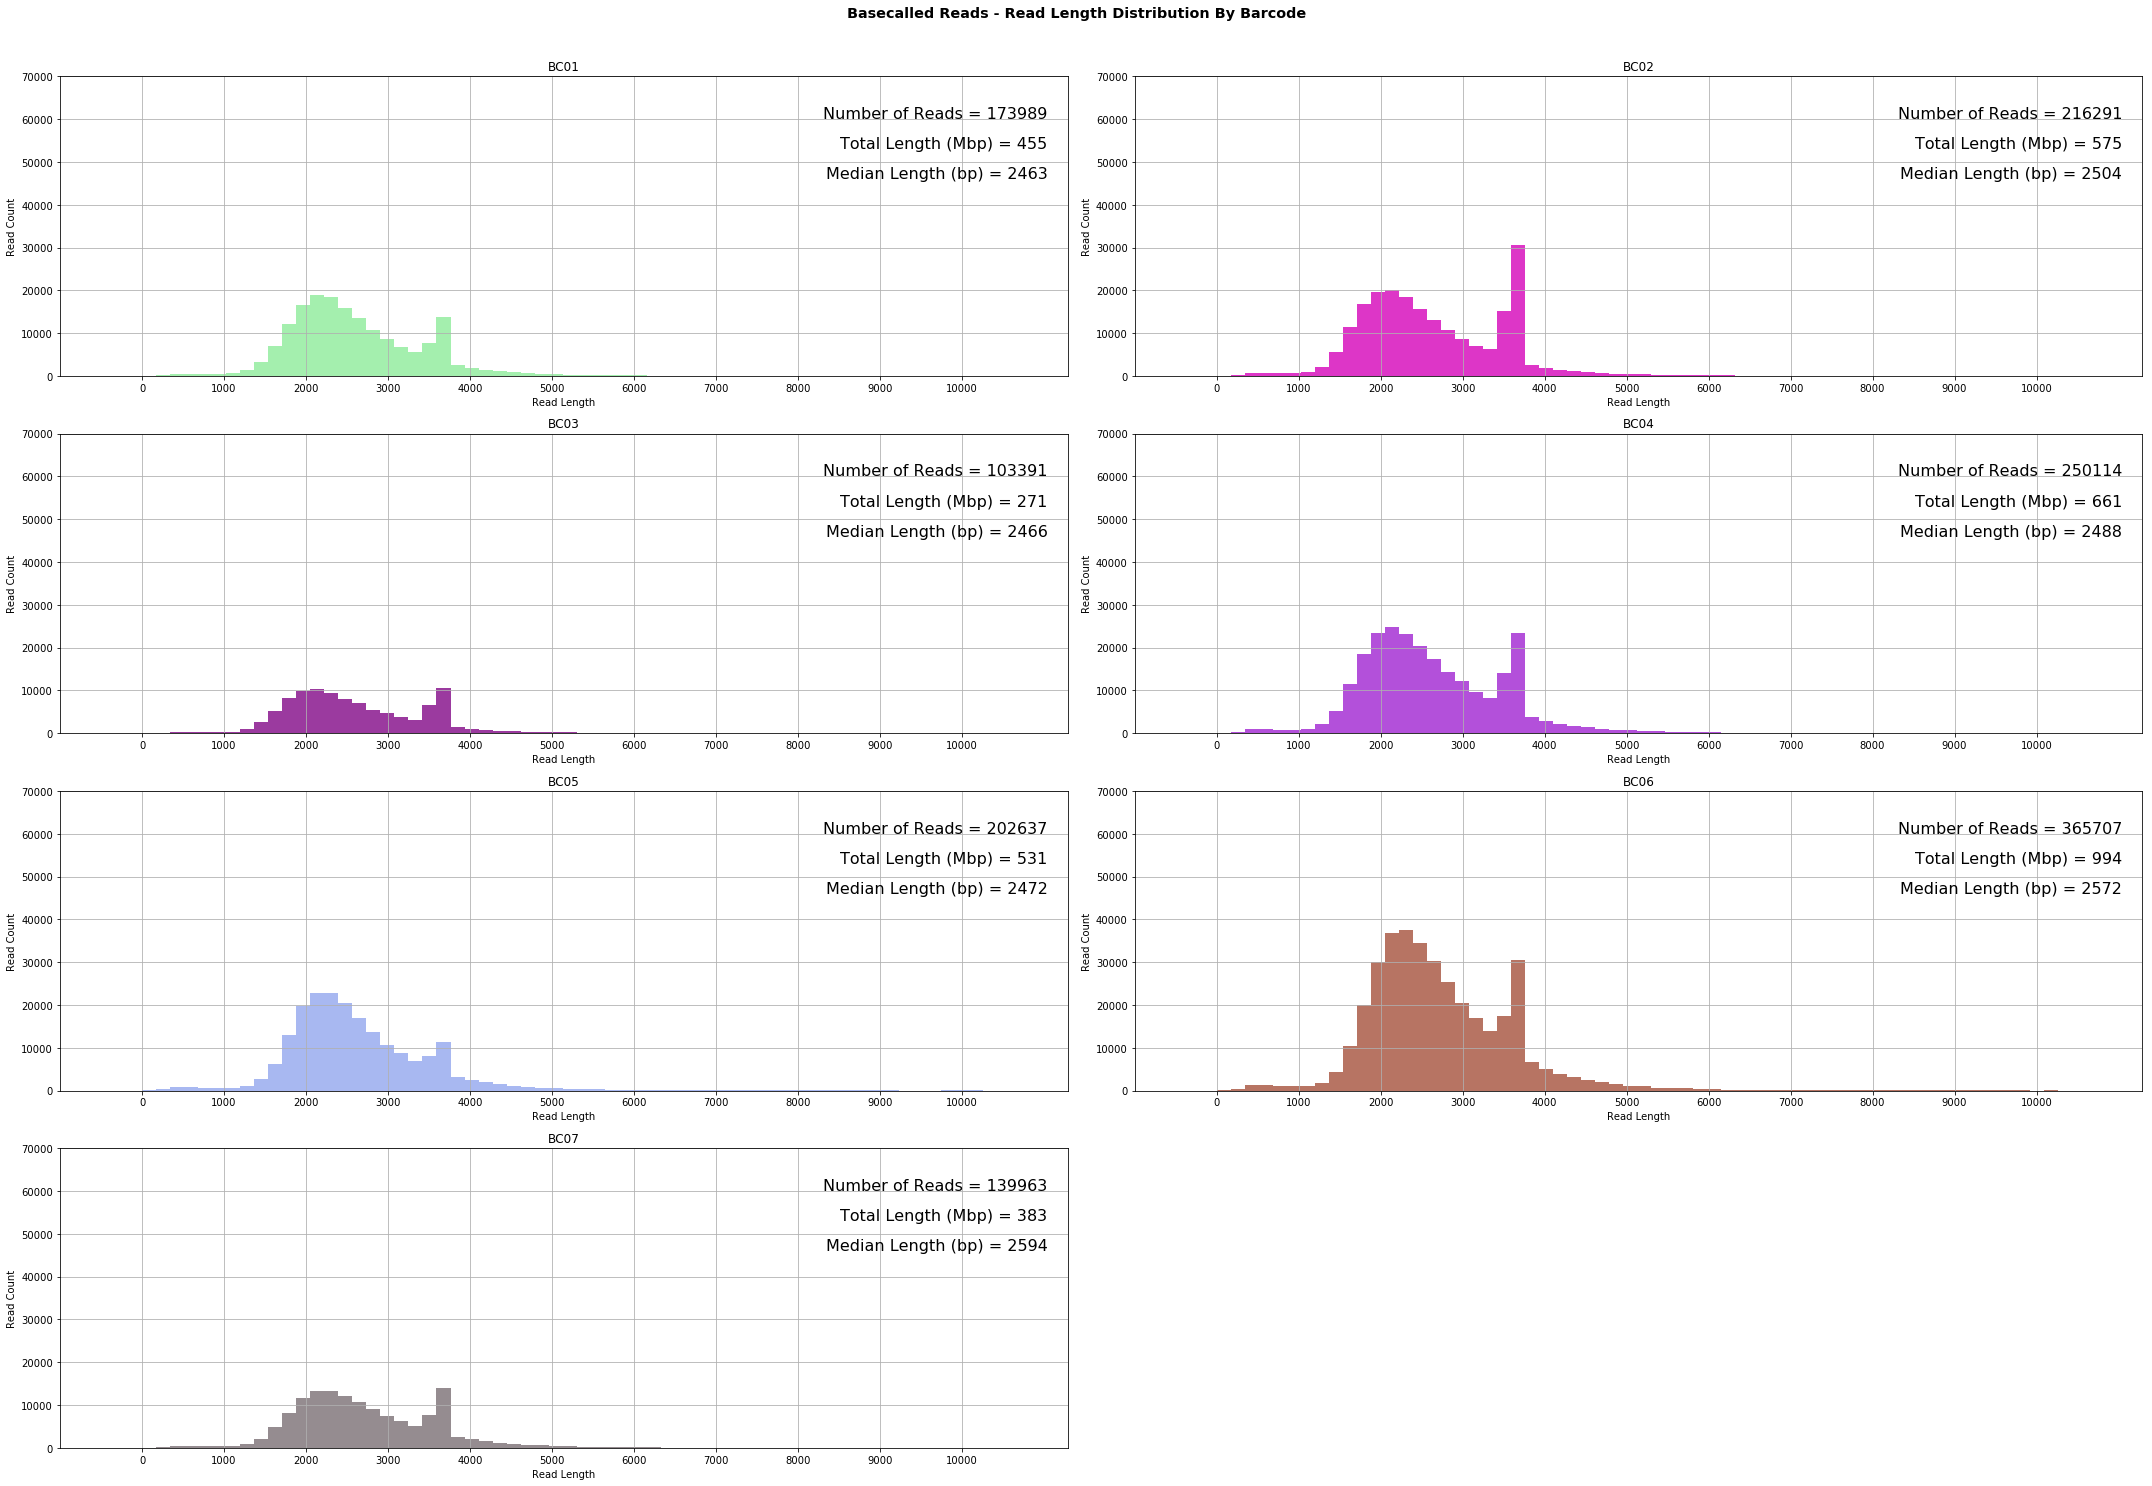

In [30]:
#do something like subset_df[subset_df.Length < subset_df.Length.mean()*4]


#Generates a histogram showing the total read length distribution for all basecalled reads per barcode
basecalled_barcodes = list(subset_df['Barcode'].unique())

if len(list(subset_df['Barcode'].unique())) % 2 == 0:
    no_of_subplots = len(basecalled_barcodes)
else:
    no_of_subplots = len(basecalled_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(30,20))

xmax = int(subset_df.Length.max())

max_count_list = []
for bcs in list(subset_df['Barcode'].unique()):
    max_count_list.append(np.histogram(subset_df.loc[subset_df['Barcode'] == bcs] ['Length'], 60)[0].max())
max_count_list.sort()
max_count_list_max = max_count_list[-1]
max_count_list_max_digits = len(str(max_count_list_max))
exact_ylim = (int(max_count_list_max / 10**(max_count_list_max_digits-1))+1)*(10**(max_count_list_max_digits-1))

def applyGroupHistograms(ax_ind1, ax_ind2, bcs):
    ax[ax_ind1, ax_ind2].hist(subset_df.groupby('Barcode')['Length'].get_group(bcs), 
                              bins=range(0, xmax, int(xmax/60)), 
                              color=random_color(), 
                              alpha=0.8)
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].set_xlabel('Read Length')
    ax[ax_ind1, ax_ind2].set_ylabel('Read Count');
    ax[ax_ind1, ax_ind2].set_xlim([-1000, subset_df['Length'].max() + 1000])
    ax[ax_ind1, ax_ind2].set_xticks(np.arange(0, xmax + 1, 1000))
    ax[ax_ind1, ax_ind2].set_ylim(0, exact_ylim)
    ax[ax_ind1, ax_ind2].grid(True, which='Major')
 #this adds the text to the    
    for idx, clmn_name in enumerate(['Number of Reads', 'Total Length (Mbp)', 'Median Length (bp)']):
        ax[ax_ind1, ax_ind2].annotate(clmn_name + ' = ' + str(int(basecalled_df_pivot_formal.loc[bcs, clmn_name])), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')

for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_rows, subplot_coordinates_list_columns, bc_list):
    applyGroupHistograms(ax_ind1, ax_ind2, bcs)    

if len(list(subset_df['Barcode'].unique())) != 0:
    plt.delaxes(ax[subplot_coordinates_list_rows[-1], subplot_coordinates_list_columns[-1]])

plt.suptitle('Basecalled Reads - Read Length Distribution By Barcode', 
             y=1.03, 
             fontsize='x-large', 
             fontweight='bold')
plt.tight_layout()
plt.savefig(work_dir + 'analysis/graphs/' + basecalled_fasta_file_id + 'basecalled_read_distribution_bcsort.png', bbox_inches='tight')    
    

In [31]:
int(basecalled_df_pivot_formal.loc[bcs, clmn_name])

2277

In [32]:
### DATAFRAME ANALYSIS - COLLATION OF RGBESTHIT DATA ###

In [33]:
#Extracts rgblast files from the initial input folder and moves them to data/basecalled to be manipulated
rgblast_input_file_names = [x for x in os.listdir(rgbesthit_input_dir_path) if x.endswith('WW_30032017.blast.besthit')]
rgblast_input_file_names.sort()
if rgblast_input_file_names:
    rgblast_file_type = get_file_type(rgblast_input_file_names[-1], '.')

    for rgblast_file in rgblast_input_file_names:
        if os.path.exists(rgbesthit_input_dir_path + rgblast_file):
            if not os.path.exists(work_dir + 'blast/rgbesthit/' + rgblast_file):
                shutil.copy2(rgbesthit_input_dir_path + rgblast_file, work_dir + 'blast/rgbesthit/' + rgblast_file)